In [1]:
%matplotlib inline 
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.metrics import accuracy_score
import xgboost

In [2]:
files =  [filo for filo in os.listdir("data") if ".csv" in filo]
print files

def read_chunk(file_name, chunksize=1000000, resample=None):
    print resample
    chunks = pd.read_csv("data/"+file_name,parse_dates=['Time (UTC)'], chunksize=chunksize)
    df = pd.DataFrame()
    for _ in chunks:
        _.rename(columns={'Time (UTC)':'Time'}, inplace=True)
        _.rename(columns={'BidVolume ':'BidVolume'}, inplace=True)
        _.set_index('Time', inplace=True)
        _ = _.resample(resample).mean()
        _['spread']=_['Ask']-_['Bid']
        _['spread_volume']=_['AskVolume']-_['BidVolume']
        df = pd.concat([df,_],axis=0)
        
       
    df.to_csv('data/resampled/'+file_name.split(".csv")[0]+"_resampled_"+resample+'.csv')

['EURUSD_UTC_Ticks_Bid_2016.08.02_2016.11.22.csv', 'GBPUSD_UTC_Ticks_Bid_2016.08.02_2016.11.22.csv', 'EURGBP_UTC_Ticks_Bid_2016.08.02_2016.11.22.csv']


In [3]:
def create_file(resample=None):
    for filo in files:
        read_chunk(file_name=filo,resample=resample)
        
def combine_files(resample=None):
    onlyfiles = [f for f in os.listdir('data/resampled/') if os.path.isfile(os.path.join('data/resampled/', f))]
    onlyfiles= [filo for filo in onlyfiles if "_"+ resample+".csv" in filo]
    
    df_all = pd.DataFrame()
    for filo in onlyfiles:
        df=pd.read_csv(os.path.join('data/resampled/', filo),parse_dates=['Time'],index_col=0)
        df.columns = [col+"_"+filo[:6] for col in df.columns.tolist()]
        df.reset_index() 
        
        try:
            df_all = pd.merge(df.reset_index(),df_all, on='Time', how='outer')
        except KeyError:
            df_all = df.reset_index()
    return df_all

def add_calendar_data(df):
    df['cal_hour']= df.Time.dt.hour
    df['cal_minute'] = df.Time.dt.minute
    df['cal_dayofweek']= df.Time.dt.dayofweek
    df['cal_dayofyear']= df.Time.dt.dayofyear
    df.rename(columns={'Time':'cal_time'}, inplace=True)
    

def split_data_on_date(df,date_str):
    date_until = datetime.strptime(date_str, '%Y-%m-%d')

    training_df = df[df.cal_time<date_until]
    forecast_df = df[df.cal_time>=date_until]
    return training_df,forecast_df


def regularize(df):
    reg_col = [col for col in df.columns.tolist() if not "cal_" in col]
    for col in reg_col:
        df[col+"_reg"] = (df[col]-df[col].mean())/df[col].std()
    

def create_dataset(df, target, until_date):
    X_y_dict ={}
    training_df,forecast_df = split_data_on_date(df,until_date)
    
    
    features_col = [col for col in df.columns if ("reg" in col or "cal_" in col)]
    features_col = [col for col in features_col if target.split('_')[1] not in col]
    print features_col
    
    
    features_col.remove('cal_time')
    print features_col
    X_y_dict['training_X'] = training_df[features_col].values
    X_y_dict['training_y'] =  training_df[target].values
    
    X_y_dict['forecast_X'] = forecast_df[features_col].values
    
    X_y_dict['observed_y'] =  forecast_df[target].values
    
    X_y_dict['label_training'] = training_df.cal_time.values
    X_y_dict['label_forecast'] = forecast_df.cal_time.values
    
    X_y_dict['features_names'] = features_col
    
    return X_y_dict

In [4]:
#create_file(resample='10Min')
df = combine_files(resample='10Min')
add_calendar_data(df)
regularize(df)
df = df[pd.notnull(df.Ask_EURGBP)]
df = df[pd.notnull(df.Ask_GBPUSD)]
df = df[pd.notnull(df.Ask_EURUSD)]
dataset = create_dataset(df,'Ask_EURGBP',"2016-11-18")



['cal_time', 'cal_hour', 'cal_minute', 'cal_dayofweek', 'cal_dayofyear', 'Ask_GBPUSD_reg', 'Bid_GBPUSD_reg', 'AskVolume_GBPUSD_reg', 'BidVolume_GBPUSD_reg', 'spread_GBPUSD_reg', 'spread_volume_GBPUSD_reg', 'Ask_EURUSD_reg', 'Bid_EURUSD_reg', 'AskVolume_EURUSD_reg', 'BidVolume_EURUSD_reg', 'spread_EURUSD_reg', 'spread_volume_EURUSD_reg']
['cal_hour', 'cal_minute', 'cal_dayofweek', 'cal_dayofyear', 'Ask_GBPUSD_reg', 'Bid_GBPUSD_reg', 'AskVolume_GBPUSD_reg', 'BidVolume_GBPUSD_reg', 'spread_GBPUSD_reg', 'spread_volume_GBPUSD_reg', 'Ask_EURUSD_reg', 'Bid_EURUSD_reg', 'AskVolume_EURUSD_reg', 'BidVolume_EURUSD_reg', 'spread_EURUSD_reg', 'spread_volume_EURUSD_reg']


In [5]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters,
                          cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters,
                          n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best


def do_classify(clf, parameters, X, y,
                mask=None, score_func=None, n_folds=10, n_jobs=1):
    # remove index and idbldsite

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,
                                                    test_size=0.2)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain,
                      n_jobs=n_jobs, n_folds=n_folds,
                      score_func=score_func)
    clf = clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)

    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print "########################################################"
    print "Features importance : ", clf.feature_importances_
    return clf, Xtrain, ytrain, Xtest, ytest, test_accuracy


def get_features_importance(clf, features):
    features_weighted = zip(features, clf.feature_importances_)
    features_weighted.sort(key=lambda tup: tup[1], reverse=True)

    feat_list = []
    for name, weight in features_weighted:
        feat_dict = {"name": name, "weight": weight}
        feat_list.append(feat_dict)

    return feat_list[:10]

def make_prediction(label, dataset):
        
        clf_RDM = {'params': {'n_estimators': [300], 'bootstrap': [
            True], 'criterion': ['mse']}, 'clf': RandomForestRegressor()}

        clf = clf_RDM['clf']
        params = clf_RDM['params']
        clf_rdm, Xtrain, ytrain, Xtest, ytest, r2 = \
            do_classify(clf, params, dataset['training_X'], dataset['training_y'])

        prediction = clf_rdm.predict(dataset['forecast_X'])
        

        prediction_df  = pd.DataFrame({'predicted':prediction,'observed':dataset['observed_y']}
            , index=dataset['label_forecast'])

        df_features = pd.DataFrame({'feature':dataset['features_names'],'weight':clf_rdm.feature_importances_})
        return prediction_df, df_features

        


In [6]:
prediction,features = make_prediction('Ask_EURGBP',dataset)

BEST {'n_estimators': 300, 'bootstrap': True, 'criterion': 'mse'} 0.99960271134 [mean: 0.99960, std: 0.00017, params: {'n_estimators': 300, 'bootstrap': True, 'criterion': 'mse'}]
############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     1.00
########################################################
Features importance :  [  2.58588394e-04   4.00124288e-06   1.23217651e-04   1.52166481e-01
   3.90790680e-01   4.31028101e-01   2.36877504e-05   2.49779528e-05
   6.54167071e-05   9.95821065e-06   1.25099815e-02   1.28948409e-02
   1.63003868e-05   1.59511246e-05   5.74407839e-05   1.03759043e-05]


In [7]:
features

,feature,weight
0,cal_hour,0.000259
1,cal_minute,0.000004
2,cal_dayofweek,0.000123
3,cal_dayofyear,0.152166
4,Ask_GBPUSD_reg,0.390791
5,Bid_GBPUSD_reg,0.431028
6,AskVolume_GBPUSD_reg,0.000024
7,BidVolume_GBPUSD_reg,0.000025
8,spread_GBPUSD_reg,0.000065
9,spread_volume_GBPUSD_reg,0.000010


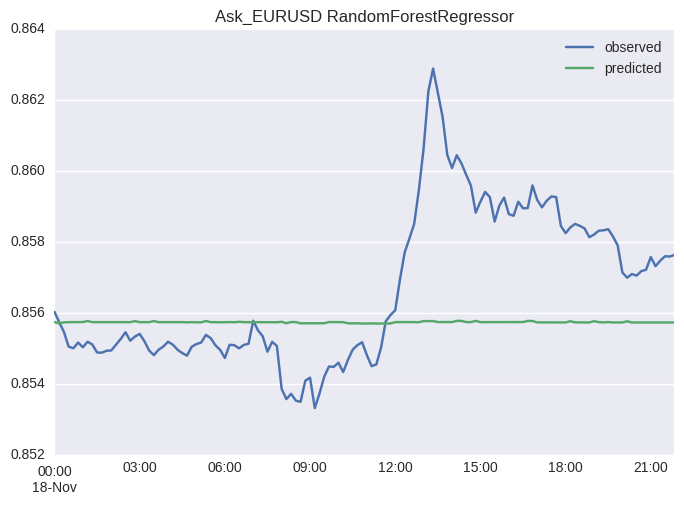

In [8]:
#prediction[(prediction.index>=datetime(2016,11,7)) & (prediction.index<datetime(2016,11,10))].plot()
prediction[prediction.index<datetime(2016,11,19)].plot(title="Ask_EURUSD RandomForestRegressor")


In [9]:
def xgbooster(dataset):
    model = xgboost.XGBRegressor()
    model.fit(dataset['training_X'], dataset['training_y'])
    print model
    predictions = model.predict(dataset['forecast_X'])
    print type(predictions)
    print dataset['observed_y'].shape
    #print accuracy_score(dataset['observed_y'], y_pred)
    prediction_df  = pd.DataFrame({'predicted':predictions,'observed':dataset['observed_y']}
            , index=dataset['label_forecast'])
    
    return prediction_df
                      

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
<type 'numpy.ndarray'>
(202,)


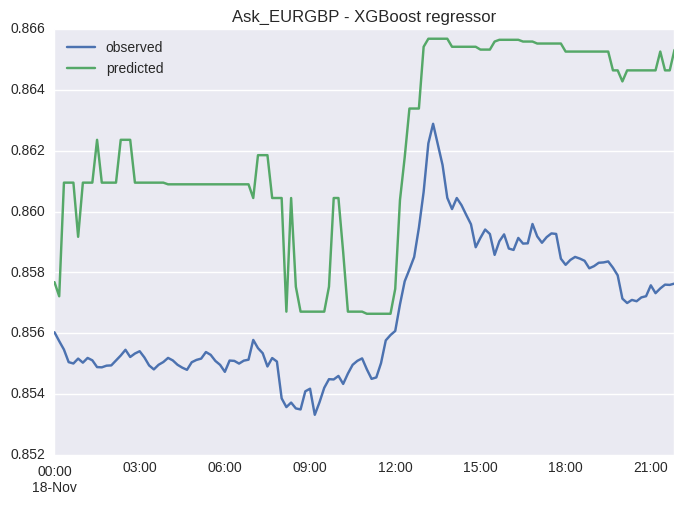

In [10]:
df_prediction = xgbooster(dataset)
df_prediction[df_prediction.index<datetime(2016,11,19)].plot(title="Ask_EURGBP - XGBoost regressor")